### Predictive Model Findings

A grouped logistic regression model was estimated to predict on-time probability 
using line, day type, and monthly precipitation.

Key findings:

- Weekend service significantly improves on-time probability relative to weekdays.
- Lines B, 2, F, and N show statistically significant underperformance relative to baseline lines.
- Monthly precipitation has a statistically detectable but economically negligible effect at this aggregation level.

Operational takeaway:
Structural operational differences between lines and weekday congestion patterns 
are far stronger predictors of performance than weather at the monthly level.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load MTA dataset (monthly aggregated by line + day_type)
df = pd.read_csv("../data/mta_terminal_otp_beginning_2025.csv")

# Parse dates / enforce types
df["month"] = pd.to_datetime(df["month"])
df["day_type"] = df["day_type"].astype(int)

# Basic checks
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Shape: (540, 7)
Columns: ['month', 'division', 'line', 'day_type', 'num_on_time_trips', 'num_sched_trips', 'terminal_on_time_performance']


,month,division,line,day_type,num_on_time_trips,num_sched_trips,terminal_on_time_performance
0,2025-01-01,A DIVISION,1,1,8510,10164,0.837269
1,2025-01-01,A DIVISION,1,2,2335,2847,0.820162
2,2025-01-01,A DIVISION,2,1,5065,7100,0.713380
3,2025-01-01,A DIVISION,2,2,1358,2140,0.634579
4,2025-01-01,A DIVISION,3,1,5396,6562,0.822310


## 1) Line performance (weighted on-time rate)

Because the data is aggregated, we compute a **weighted on-time rate** per line:

\[
\text{Weighted On-Time Rate} = \frac{\sum \text{on_time_trips}}{\sum \text{scheduled_trips}}
\]


In [3]:
line_summary = (
    df.groupby("line")
    .apply(lambda x: pd.Series({
        "total_sched_trips": x["num_sched_trips"].sum(),
        "total_on_time_trips": x["num_on_time_trips"].sum(),
        "weighted_on_time_rate": x["num_on_time_trips"].sum() / x["num_sched_trips"].sum(),
    }))
    .reset_index()
)

line_summary_sorted = line_summary.sort_values("weighted_on_time_rate")
line_summary_sorted.head(10)


/var/folders/0d/hm4k81gd2919w8jb26n2klfw0000gn/T/ipykernel_7635/932564615.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("line")


,line,total_sched_trips,total_on_time_trips,weighted_on_time_rate
8,B,54804.0,39209.0,0.715440
1,2,111105.0,80139.0,0.721291
12,F,122207.0,90249.0,0.738493
17,N,146577.0,112009.0,0.764165
9,C,73125.0,56459.0,0.772089
11,E,126969.0,99492.0,0.783593
10,D,102016.0,82524.0,0.808932
18,Q,111813.0,90913.0,0.813081
2,3,97662.0,79416.0,0.813172
7,A,128473.0,105035.0,0.817565


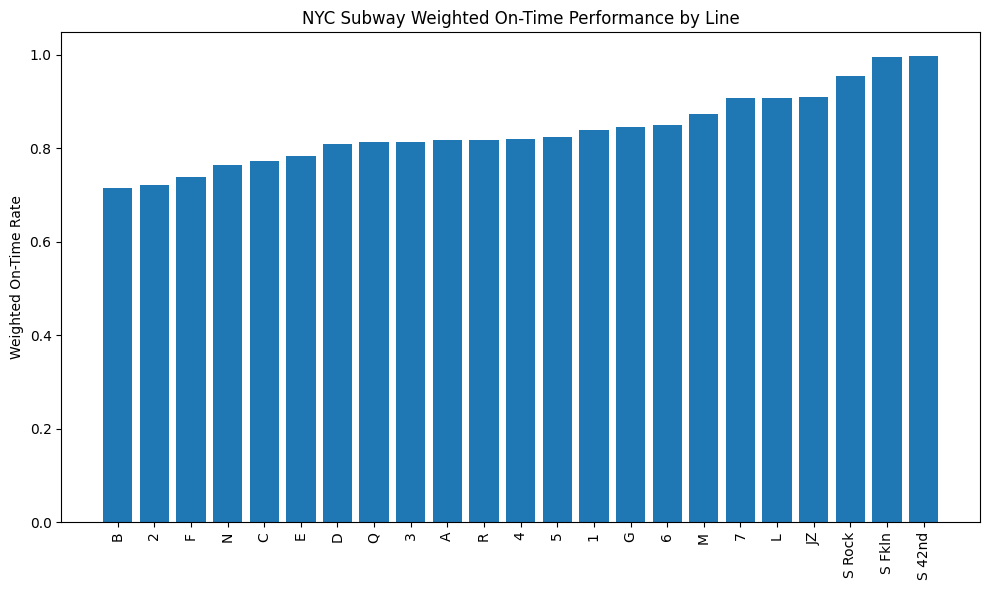

In [4]:
plt.figure(figsize=(10,6))
plt.bar(line_summary_sorted["line"].astype(str), line_summary_sorted["weighted_on_time_rate"])
plt.xticks(rotation=90)
plt.ylabel("Weighted On-Time Rate")
plt.title("NYC Subway Weighted On-Time Performance by Line")
plt.tight_layout()
plt.show()


## 2) Impact framing: absolute late-trip burden

A low on-time rate matters more when a line has high volume.

We approximate “burden” using:

\[
\text{Late Trips} = \text{Scheduled Trips} - \text{On-Time Trips}
\]

This is not “delay minutes,” but it is a clear operational impact proxy.


In [5]:
impact_summary = (
    df.groupby("line")
    .apply(lambda x: pd.Series({
        "total_sched_trips": x["num_sched_trips"].sum(),
        "total_on_time_trips": x["num_on_time_trips"].sum(),
        "total_late_trips": x["num_sched_trips"].sum() - x["num_on_time_trips"].sum(),
    }))
    .reset_index()
    .sort_values("total_late_trips", ascending=False)
)

impact_summary.head(10)


/var/folders/0d/hm4k81gd2919w8jb26n2klfw0000gn/T/ipykernel_7635/3255707893.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("line")


,line,total_sched_trips,total_on_time_trips,total_late_trips
17,N,146577,112009,34568
12,F,122207,90249,31958
1,2,111105,80139,30966
11,E,126969,99492,27477
5,6,178952,151818,27134
0,1,155951,130798,25153
7,A,128473,105035,23438
3,4,123927,101668,22259
18,Q,111813,90913,20900
10,D,102016,82524,19492


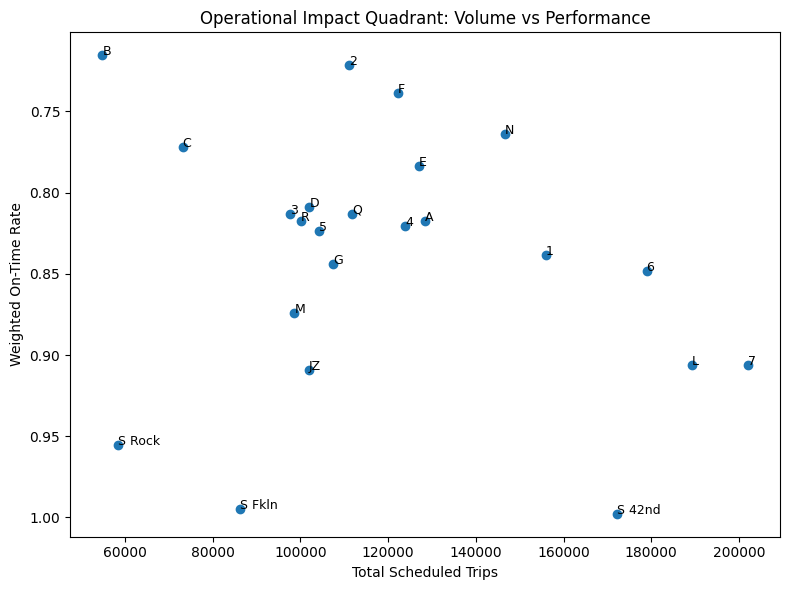

In [6]:
# Quadrant plot: Volume vs Performance
# High volume + low performance = top priority

# Build a lookup for performance
rate_lookup = line_summary.set_index("line")["weighted_on_time_rate"]

plt.figure(figsize=(8,6))
x = impact_summary["total_sched_trips"]
y = impact_summary["line"].map(rate_lookup)

plt.scatter(x, y)

for i, line in enumerate(impact_summary["line"]):
    plt.text(x.iloc[i], y.iloc[i], str(line), fontsize=9)

plt.xlabel("Total Scheduled Trips")
plt.ylabel("Weighted On-Time Rate")
plt.title("Operational Impact Quadrant: Volume vs Performance")
plt.gca().invert_yaxis()  # visually: worse performance higher urgency
plt.tight_layout()
plt.show()


## 3) Weekday vs weekend (day_type)

`day_type` in this dataset behaves like:
- **1 = higher volume** and lower on-time (weekday-like)
- **2 = lower volume** and higher on-time (weekend-like)

We quantify both rate and volume.


In [7]:
daytype_volume = df.groupby("day_type")["num_sched_trips"].sum()
daytype_rate = (
    df.groupby("day_type")
    .apply(lambda x: x["num_on_time_trips"].sum() / x["num_sched_trips"].sum())
)

print("Total scheduled trips by day_type:\n", daytype_volume, "\n")
print("Weighted on-time rate by day_type:\n", daytype_rate, "\n")

weekday_rate = daytype_rate.loc[1]
weekend_rate = daytype_rate.loc[2]
gap = weekday_rate - weekend_rate

print("Weekday On-Time Rate:", round(weekday_rate, 4))
print("Weekend On-Time Rate:", round(weekend_rate, 4))
print("Performance Gap (Weekday - Weekend):", round(gap, 4), " (negative means weekdays worse)")


Total scheduled trips by day_type:
 day_type
1    2120588
2     633536
Name: num_sched_trips, dtype: int64 

Weighted on-time rate by day_type:
 day_type
1    0.837629
2    0.866124
dtype: float64 

Weekday On-Time Rate: 0.8376
Weekend On-Time Rate: 0.8661
Performance Gap (Weekday - Weekend): -0.0285  (negative means weekdays worse)


/var/folders/0d/hm4k81gd2919w8jb26n2klfw0000gn/T/ipykernel_7635/1758984587.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("day_type")


## 4) Weather integration (monthly)

Because this dataset is monthly-aggregated, we merge **monthly** NYC weather.

Important limitation:
Weather effects are often daily/hourly; monthly aggregation may wash out true effects.


In [8]:
from meteostat import Point, Daily

start = df["month"].min()
end = df["month"].max() + pd.offsets.MonthEnd(0)

nyc = Point(40.7812, -73.9665)  # Central Park-ish
wx_daily = Daily(nyc, start, end).fetch().reset_index()
wx_daily.rename(columns={"time": "date"}, inplace=True)

wx_daily["month"] = wx_daily["date"].dt.to_period("M").dt.to_timestamp()

wx_monthly = (
    wx_daily.groupby("month")
    .agg(
        tavg_mean=("tavg", "mean"),
        prcp_sum=("prcp", "sum"),
        snow_sum=("snow", "sum"),
        wspd_mean=("wspd", "mean"),
    )
    .reset_index()
)

df2 = df.merge(wx_monthly, on="month", how="left")

print("Merged shape:", df2.shape)
df2.head()


Merged shape: (540, 11)


,month,division,line,day_type,num_on_time_trips,num_sched_trips,terminal_on_time_performance,tavg_mean,prcp_sum,snow_sum,wspd_mean
0,2025-01-01,A DIVISION,1,1,8510,10164,0.837269,-0.316129,19.6,22.0,12.512903
1,2025-01-01,A DIVISION,1,2,2335,2847,0.820162,-0.316129,19.6,22.0,12.512903
2,2025-01-01,A DIVISION,2,1,5065,7100,0.713380,-0.316129,19.6,22.0,12.512903
3,2025-01-01,A DIVISION,2,2,1358,2140,0.634579,-0.316129,19.6,22.0,12.512903
4,2025-01-01,A DIVISION,3,1,5396,6562,0.822310,-0.316129,19.6,22.0,12.512903


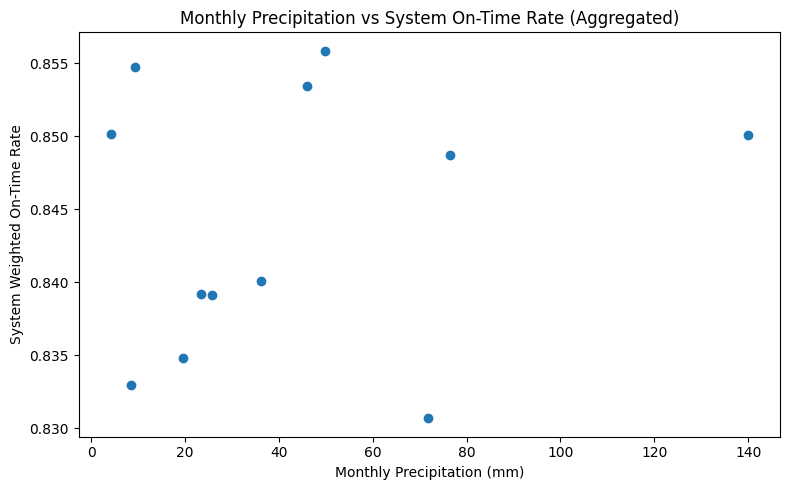

,system_on_time,prcp_sum,snow_sum
system_on_time,1.000000,0.175051,-0.693737
prcp_sum,0.175051,1.000000,-0.241339
snow_sum,-0.693737,-0.241339,1.000000


In [9]:
# System-wide monthly on-time vs precipitation (visual check)
system_monthly = (
    df2.groupby("month")
    .apply(lambda x: pd.Series({
        "system_on_time": x["num_on_time_trips"].sum() / x["num_sched_trips"].sum(),
        "prcp_sum": x["prcp_sum"].mean(),
        "snow_sum": x["snow_sum"].mean(),
    }))
    .reset_index()
    .sort_values("month")
)

plt.figure(figsize=(8,5))
plt.scatter(system_monthly["prcp_sum"], system_monthly["system_on_time"])
plt.xlabel("Monthly Precipitation (mm)")
plt.ylabel("System Weighted On-Time Rate")
plt.title("Monthly Precipitation vs System On-Time Rate (Aggregated)")
plt.tight_layout()
plt.show()

system_monthly[["system_on_time","prcp_sum","snow_sum"]].corr()


## 5) Simple predictive model (grouped logistic regression)

We model probability of being on-time using:

- `day_type` (weekday-like vs weekend-like)
- `line` (categorical)
- `prcp_sum` (monthly precipitation)

Because the data is aggregated counts, we use a **grouped binomial GLM**:
Successes = `num_on_time_trips`  
Failures  = `late_trips`


In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model_df = df2.copy()
model_df["late_trips"] = model_df["num_sched_trips"] - model_df["num_on_time_trips"]
model_df["prcp_sum"] = model_df["prcp_sum"].fillna(0)

model = smf.glm(
    formula="num_on_time_trips + late_trips ~ day_type + C(line) + prcp_sum",
    data=model_df,
    family=sm.families.Binomial()
).fit()

print(model.summary())


                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['num_on_time_trips', 'late_trips']   No. Observations:                  540
Model:                                             GLM   Df Residuals:                      515
Model Family:                                 Binomial   Df Model:                           24
Link Function:                                   Logit   Scale:                          1.0000
Method:                                           IRLS   Log-Likelihood:                -17896.
Date:                                 Tue, 17 Feb 2026   Deviance:                       31660.
Time:                                         18:52:48   Pearson chi2:                 3.15e+04
No. Iterations:                                      9   Pseudo R-squ. (CS):              1.000
Covariance Type:                             nonrobust                                         
                        coef    std err 

## Key takeaways (draft)

- **Operational prioritization:** Lines that combine high volume with weak performance create the largest late-trip burden (e.g., N line).
- **Weekday penalty:** Day_type 1 shows substantially higher volume and ~2–3 percentage points lower on-time performance than day_type 2.
- **Weather (monthly):** Correlation and model coefficient are statistically detectable but economically small at this aggregation level.
- **Model validation:** Line effects and day_type effects strongly align with descriptive EDA, providing a consistent narrative.


In [11]:
# Create prediction grid
pred_df = pd.DataFrame({
    "line": ["N", "B", "2", "A"],
    "day_type": [1, 2] * 2
})

# Expand to get both weekday and weekend for each line
pred_df = pd.DataFrame({
    "line": ["N","N","B","B","2","2","A","A"],
    "day_type": [1,2,1,2,1,2,1,2],
    "prcp_sum": 0  # hold precipitation constant
})

# Predict log-odds
pred_df["predicted_prob_on_time"] = model.predict(pred_df)

pred_df


,line,day_type,prcp_sum,predicted_prob_on_time
0,N,1,0,0.756063
1,N,2,0,0.787732
2,B,1,0,0.712796
3,B,2,0,0.748212
4,2,1,0,0.709662
5,2,2,0,0.745326
6,A,1,0,0.809071
7,A,2,0,0.835357
